In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
from numpy import array as arr

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.model_selection import KFold
from torch.utils.data import ConcatDataset, DataLoader, Dataset, TensorDataset, random_split, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from statistics import mean
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

seed_value = 12321
torch.manual_seed(seed_value)
np.random.seed(seed_value)

if torch.cuda.is_available():  
  device = "cuda:0" 
else:  
  device = "cpu"
print(device)

cuda:0


In [7]:
url_df_plant_1_processed_sliding_window_changed = 'https://raw.githubusercontent.com/JERRITE/DeepLearning-Windenergy-Project2022/main/data/df_plant_1_processed_sliding_window_changed.csv'
url_df_plant_1_processed_final_changed = 'https://raw.githubusercontent.com/JERRITE/DeepLearning-Windenergy-Project2022/main/data/df_plant_1_processed_final_changed.csv'
df_plant_1_processed_final = pd.read_csv(url_df_plant_1_processed_final_changed, index_col = 0)
df_plant_1_processed_sliding_window = pd.read_csv(url_df_plant_1_processed_sliding_window_changed, index_col = 0)
df_plant_1_processed_final.index = pd.to_datetime(df_plant_1_processed_final.index)
df_plant_1_processed_sliding_window.index = pd.to_datetime(df_plant_1_processed_sliding_window.index)

In [8]:
df_plant_1_processed_final.drop(columns = ["hours", "index_forecasted_weather"]).head()

,u,v,ws,wd_sin,wd_cos,month_sin,month_cos,hour_sin,hour_cos,wp1
2009-07-01 01:00:00,0.233662,-0.198982,-0.862185,0.928484,-0.382437,0.310662,-1.335029,0.366025,1.366025,0.085
2009-07-01 02:00:00,0.181121,-0.268072,-0.910722,0.873757,-0.518663,0.310662,-1.335029,0.707107,1.224745,0.020
2009-07-01 03:00:00,0.187689,-0.344071,-0.834758,0.821647,-0.621071,0.310662,-1.335029,1.000000,1.000000,0.060
2009-07-01 04:00:00,0.236946,-0.409707,-0.687669,0.793305,-0.669613,0.310662,-1.335029,1.224745,0.707107,0.045
2009-07-01 05:00:00,0.296054,-0.433888,-0.559017,0.803136,-0.653249,0.310662,-1.335029,1.366025,0.366025,0.035


## Data Preprocessing and Packing

In [ ]:
df_sliding_window = df_plant_1_processed_sliding_window
df_weather_forecast = df_plant_1_processed_final

BATCHES_EXCLUDED = 15
WINDOW_SIZE = 12*BATCHES_EXCLUDED

INTERVAL = 48
TIMES_ONE_DATASET = 12
NUMBER_OF_48_PERIODS = int(df_weather_forecast.shape[0] / INTERVAL)
MORE_DATA_FOR_TRAINING = 12
PADDED_VALUE = -0.2
STEPS_TO_THE_PAST = 25

result = []
result_target = []

list_of_df_sliding_global = []
list_of_last_wp_global = []
list_of_current = []

window_size = WINDOW_SIZE
for i in range(NUMBER_OF_48_PERIODS - BATCHES_EXCLUDED):
    iterator = i + BATCHES_EXCLUDED
    df_temp = df_weather_forecast.iloc[INTERVAL*iterator: INTERVAL*(iterator+1), :]
    assert np.unique(df_temp.loc[:, "index_forecasted_weather"].values).shape[0] == 1
    array_values = df_temp.drop(columns = ["index_forecasted_weather", "hours"]).values

    end_sliding_window = df_temp.index[0] - pd.Timedelta(hours = 1)
    start_sliding_window = df_temp.index[0] - pd.Timedelta(hours = window_size)
    # MORE DATA FOR TRAINING
    end_sliding_window = end_sliding_window + pd.Timedelta(hours = MORE_DATA_FOR_TRAINING)
    df_window = df_sliding_window.loc[start_sliding_window:end_sliding_window, :]
    df_window = df_window.drop(columns = ["index_forecasted_weather", "hours"])

    target_list = array_values[:, array_values.shape[1] - 1][:, None]
    target_list_padded_values = np.full((array_values.shape[0] + 12, 1), fill_value = PADDED_VALUE)
    final_target_list = np.vstack((target_list, target_list_padded_values))

    explanatory_list = array_values[:, 0:(array_values.shape[1] - 1)]
    explanatory_list_padded_value = np.full((12, array_values.shape[1] - 1), fill_value = PADDED_VALUE)
    final_explanatory_list = np.vstack((explanatory_list, explanatory_list_padded_value))

    list_of_df_sliding = []
    list_of_last_wp = []
    explanatory_48_hours = []
    target_48_hours = []
    for j in range(MORE_DATA_FOR_TRAINING):
        df_sliding_tmp = df_window.iloc[j:j+window_size, :]
        list_of_df_sliding.append(df_sliding_tmp.values)
        # PROBLEM HERE WHEN SCALING - WP1 NEEDS TO BE CHANGE FOR WP
        list_of_last_wp.append(df_sliding_tmp.wp1[-STEPS_TO_THE_PAST:].values)
        explanatory_48_hours.append(final_explanatory_list[j:j+INTERVAL, :])
        target_48_hours.append(final_target_list[j:j+INTERVAL, :])

    result.append(explanatory_48_hours)
    result_target.append(target_48_hours)

    list_of_df_sliding = arr(list_of_df_sliding)
    list_of_last_wp = arr(list_of_last_wp)

    list_of_df_sliding_global.append(list_of_df_sliding)
    list_of_last_wp_global.append(list_of_last_wp)

list_of_df_sliding_global = arr(list_of_df_sliding_global)
list_of_last_wp_global = arr(list_of_last_wp_global)[:, :, :, None]
result = arr(result)
result_target = arr(result_target)

print(list_of_df_sliding_global.shape, list_of_last_wp_global.shape, result.shape, result_target.shape)

(1080, 12, 180, 10) (1080, 12, 25, 1) (1080, 12, 48, 9) (1080, 12, 48, 1)


In [ ]:
TEST_SET_PERCENT = 0.05
VALIDATION_SET_PERCENT = 0.05

TRUE_SIZE = NUMBER_OF_48_PERIODS - BATCHES_EXCLUDED
test_size = int(TRUE_SIZE * TEST_SET_PERCENT)
validation_size = int((TRUE_SIZE - test_size) * VALIDATION_SET_PERCENT)
train_size = TRUE_SIZE - validation_size - test_size
assert TRUE_SIZE == test_size + validation_size + train_size
train_size, validation_size, test_size

(975, 51, 54)

In [ ]:
sliding_window = list_of_df_sliding_global
X_encoder_decoder = list_of_last_wp_global
X = result
y = result_target

In [ ]:
# special == 3 implies that the max prediction horizon is 36 hours
SPECIAL = 3

sw_train = sliding_window[0:train_size - SPECIAL]
sw_train_special = sliding_window[train_size - SPECIAL:train_size]
sw_val = sliding_window[train_size: train_size + validation_size - SPECIAL, 0:1]
sw_val_special = sliding_window[train_size + validation_size - SPECIAL: train_size + validation_size, 0:1]
sw_test = sliding_window[train_size + validation_size:, 0:1]

X_ed_train = X_encoder_decoder[0:train_size - SPECIAL]
X_ed_train_special = X_encoder_decoder[train_size - SPECIAL:train_size]
X_ed_val = X_encoder_decoder[train_size: train_size + validation_size - SPECIAL, 0:1]
X_ed_val_special = X_encoder_decoder[train_size + validation_size - SPECIAL: train_size + validation_size, 0:1]
X_ed_test = X_encoder_decoder[train_size + validation_size:, 0:1]

X_train = X[0:train_size - SPECIAL]
X_train_special = X[train_size - SPECIAL:train_size]
X_val = X[train_size: train_size + validation_size - SPECIAL, 0:1]
X_val_special = X[train_size + validation_size - SPECIAL: train_size + validation_size, 0:1]
X_test = X[train_size + validation_size:, 0:1]

y_train = y[0:train_size - SPECIAL]
y_train_special = y[train_size - SPECIAL:train_size]
y_val = y[train_size: train_size + validation_size - SPECIAL, 0:1]
y_val_sepcial = y[train_size + validation_size - SPECIAL: train_size + validation_size, 0:1]
y_test = y[train_size + validation_size:, 0:1]

print(sw_train.shape, sw_train_special.shape, sw_val.shape, sw_val_special.shape, sw_test.shape)
print()
print(X_ed_train.shape, X_ed_train_special.shape, X_ed_val.shape, X_ed_val_special.shape, X_ed_test.shape)
print()
print(X_train.shape, X_train_special.shape, X_val.shape, X_val_special.shape, X_test.shape)
print()
print(y_train.shape, y_train_special.shape, y_val.shape, y_val_sepcial.shape, y_test.shape)

(972, 12, 180, 10) (3, 12, 180, 10) (48, 1, 180, 10) (3, 1, 180, 10) (54, 1, 180, 10)

(972, 12, 25, 1) (3, 12, 25, 1) (48, 1, 25, 1) (3, 1, 25, 1) (54, 1, 25, 1)

(972, 12, 48, 9) (3, 12, 48, 9) (48, 1, 48, 9) (3, 1, 48, 9) (54, 1, 48, 9)

(972, 12, 48, 1) (3, 12, 48, 1) (48, 1, 48, 1) (3, 1, 48, 1) (54, 1, 48, 1)


## DataLoaders Pytroch

In [ ]:
class Dataset_one_plant(torch.utils.data.Dataset):
    def __init__(self, sw, X_ed, X, y):
        self.sw = torch.from_numpy(sw.reshape((sw.shape[0]*sw.shape[1], sw.shape[2], sw.shape[3]))).float()
        self.X_ed = torch.from_numpy(X_ed.reshape((X_ed.shape[0]*X_ed.shape[1], X_ed.shape[2], X_ed.shape[3]))).float() 
        self.X = torch.from_numpy(X.reshape((X.shape[0]*X.shape[1], X.shape[2], X.shape[3]))).float()
        self.y = torch.from_numpy(y.reshape((y.shape[0]*y.shape[1], y.shape[2], y.shape[3]))).float()

    def __len__(self):
        return self.sw.shape[0]

    def __getitem__(self, index):
        result_dict = {}
        result_dict["sw"] = self.sw[index]
        result_dict["X_ed"] = self.X_ed[index]
        result_dict["X"] = self.X[index]
        result_dict["y"] = self.y[index]
        return result_dict

In [ ]:
dataset_train = Dataset_one_plant(sw_train, X_ed_train, X_train, y_train)
dataset_train_special = Dataset_one_plant(sw_train_special, X_ed_train_special, X_train_special, y_train_special)
dataset_val = Dataset_one_plant(sw_val, X_ed_val, X_val, y_val)
dataset_val_special = Dataset_one_plant(sw_val_special, X_ed_val_special, X_val_special, y_val_sepcial)
dataset_test = Dataset_one_plant(sw_test, X_ed_test, X_test, y_test)

In [ ]:
MULTIPLICATION = 3
BATCH_SIZE = int(12*MULTIPLICATION)
BATCH_SIZE_SPECIAL = 1
BATCH_SIZE_VAL = 1

dataloader_train = DataLoader(dataset_train, batch_size = BATCH_SIZE, shuffle = False)
dataloader_train_special = DataLoader(dataset_train_special, batch_size = BATCH_SIZE_SPECIAL, shuffle = False)
dataloader_val = DataLoader(dataset_val, batch_size = BATCH_SIZE, shuffle = False)

dataloader_val_special = DataLoader(dataset_val_special, batch_size = BATCH_SIZE_SPECIAL, shuffle = False)
dataloader_test = DataLoader(dataset_test, batch_size = BATCH_SIZE_VAL, shuffle = False)
print(len(dataloader_train), len(dataloader_train_special), len(dataloader_val),
      len(dataloader_val_special), len(dataloader_test))

324 36 2 3 54 16


## Helper functions

In [ ]:
def reset_weights(m):
  '''
 Reset model weights to avoid leakage of weights
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    layer.reset_parameters()

def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

Running GPU.


## Architecture - Encoder Decoder LSTM

In [ ]:
class lstm_encoder(nn.Module):
    ''' Encodes time-series sequence '''
    def __init__(self, n_features, hidden_size, num_layers = 1):
        
        '''
        : param n_features:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''
        super(lstm_encoder, self).__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # define LSTM layer
        self.lstm = nn.LSTM(input_size = n_features,
                            hidden_size = hidden_size,
                            num_layers = num_layers,
                            batch_first = True)
        
    def forward(self, sliding_window_encoder, hidden):
        '''
        : param sliding_window_encoder: input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:      lstm_out gives all the hidden states in the sequence;
        :                               hidden gives the hidden state and cell state for the last
        :                               element in the sequence 
        '''
        lstm_out, hidden_encoder = self.lstm(sliding_window_encoder, hidden)
        return lstm_out, hidden_encoder    
    
    def init_hidden(self, batch_size):
        '''
        initialize hidden state
        : param batch_size:    sliding_window_encoder.shape[1]
        : return:              zeroed hidden state and cell state 
        '''  
        return (get_variable(torch.zeros(self.num_layers, batch_size, self.hidden_size)),
                get_variable(torch.zeros(self.num_layers, batch_size, self.hidden_size)))
        
class lstm_decoder(nn.Module):
    ''' Decodes hidden state output by encoder '''
    def __init__(self, n_features, hidden_size, hidden_size_backward,
                 past_observations_ffnn_size,
                 num_layers = 1, n_past_steps_decoder = 1):
        '''
        : param n_features:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''
        super(lstm_decoder, self).__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.hidden_size_backward = hidden_size_backward
        self.num_layers = num_layers
        self.n_steps_head = 1
        self.past_observations_ffnn_size = past_observations_ffnn_size
        self.current_explanatory_variable_size = n_features - 1

        self.lstm = nn.LSTM(input_size = n_features, hidden_size = hidden_size,
                            num_layers = num_layers, batch_first = True)
        self.linear_inside = nn.Linear(hidden_size*n_past_steps_decoder + hidden_size_backward +
                                       self.past_observations_ffnn_size + self.current_explanatory_variable_size,
                                       hidden_size)
        self.linear_final = nn.Linear(hidden_size, self.n_steps_head) 
        self.relu = nn.ReLU()   
        self.sigmoid = nn.Sigmoid()      

    def forward(self, x_combined, hidden_state_backward, past_observations_ffnn,
                current_explanatory_variable, encoder_hidden_states):
        '''        
        : param x_combined:                 x_previous + x_predictied
        : param encoder_hidden_states:      hidden states
        : return output, hidden:            output gives all the hidden states in the sequence;
        :                                   hidden gives the hidden state and cell state for the last
        :                                   element in the sequence 
        '''
        # x_combined_packed = pack_padded_sequence(input = x_combined,
        #         lengths = seq_lengths, batch_first = True)
        # output, input_sizes = pad_packed_sequence(lstm_out, batch_first=True,
        #             padding_value = 0) 
        lstm_out, hidden_decoder = self.lstm(x_combined,
                                             encoder_hidden_states)
        lstm_concatenated = torch.cat((lstm_out, hidden_state_backward,
                                       torch.permute(past_observations_ffnn, (0, 2, 1)), 
                                       current_explanatory_variable), dim = 2)
        lstm_concatenated = torch.squeeze(lstm_concatenated)
        # print(lstm_concatenated.shape)
        output = self.linear_inside(lstm_concatenated)
        output = self.relu(output)
        output = self.linear_final(output)  
        output = self.sigmoid(output)   
        if len(output.shape) == 1:
            output = output[:, None]
        return output[:, :, None], hidden_decoder

class lstm_backward(nn.Module):
    ''' Decodes hidden state output by encoder '''
    def __init__(self, n_features, hidden_size_backward, num_layers_backward = 1):
        '''
        : param n_features:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''
        super(lstm_backward, self).__init__()
        self.n_features = n_features
        self.hidden_size_backward = hidden_size_backward
        self.num_layers_backward = num_layers_backward
        self.n_steps_head = 1

        self.lstm = nn.LSTM(input_size = n_features, hidden_size = hidden_size_backward,
                            num_layers = num_layers_backward, batch_first = True)          

    def forward(self, X, hidden_states_backward):
        '''        
        : param x_combined:                 x_previous + x_predictied
        : param encoder_hidden_states:      hidden states
        : return output, hidden:            output gives all the hidden states in the sequence;
        :                                   hidden gives the hidden state and cell state for the last
        :                                   element in the sequence 
        '''
        X_rotated_180 = torch.rot90(X, k = 2, dims = [1, 2]) # batch first
        lstm_out, hidden_backward = self.lstm(X_rotated_180, hidden_states_backward)
        lstm_out_rotated = torch.rot90(lstm_out, k = 2, dims = [1, 2]) # batch first
        return lstm_out_rotated, hidden_backward    
    
    def init_hidden(self, batch_size):
        '''
        initialize hidden state
        : param batch_size:    sliding_window_encoder.shape[1]
        : return:              zeroed hidden state and cell state 
        '''  
        return (get_variable(torch.zeros(self.num_layers_backward, batch_size, self.hidden_size_backward)),
                get_variable(torch.zeros(self.num_layers_backward, batch_size, self.hidden_size_backward)))

class lstm_seq2seq(nn.Module):
    ''' train LSTM encoder-decoder and make predictions '''
    def __init__(self, n_features, hidden_size, num_layers, hidden_size_backward,
                 num_layers_backward, past_observations_ffnn_size, n_past_steps_decoder = 1):
        '''
        : param n_features:     the number of expected features in the input X
        : param hidden_size:    the number of features in the hidden state h
        '''
        super(lstm_seq2seq, self).__init__()

        self.n_features = n_features
        self.hidden_size = hidden_size

        # 1 is added, because the decodr recieves the input feautres and the predicion
        # from the previous decoder LSTM cell
        self.encoder = lstm_encoder(n_features = n_features, hidden_size = hidden_size,
                                    num_layers = num_layers)
        self.decoder = lstm_decoder(n_features = n_features, hidden_size = hidden_size,
                                    hidden_size_backward = hidden_size_backward,
                                    n_past_steps_decoder = n_past_steps_decoder, 
                                    num_layers = num_layers, past_observations_ffnn_size = past_observations_ffnn_size)
        # we are excluding the target variable hence -1
        self.backward = lstm_backward(n_features = n_features - 1, hidden_size_backward = hidden_size_backward,
                                            num_layers_backward = num_layers_backward)

In [ ]:
n_features = dataset_train.sw.shape[-1]
hidden_size = 128
num_layers = 2
learning_rate = 3e-05
WEIGHT_DECAY = 0.033
CLIP = 5
teacher_forcing_ratio = 0.6
# training_prediction = "recursive"
# training_prediction = "teacher_forcing"
training_prediction = "mixed_teacher_forcing"
dynamic_tf = True

hidden_size_backward = 128
num_layers_backward = 1
ADDITIONAL_STEPS_FUTURE = 5
# max X_ed.shape[1] = 10
PAST_OBSERVATIONS_FFNN_SIZE = 10


NUM_EPOCHS = 30
target_len = 36

model = lstm_seq2seq(n_features = n_features, hidden_size = hidden_size, num_layers = num_layers,
                     hidden_size_backward = hidden_size_backward, num_layers_backward = num_layers_backward, 
                     past_observations_ffnn_size = PAST_OBSERVATIONS_FFNN_SIZE)

torch.nn.init.xavier_uniform_(model.decoder.linear_inside.weight)
torch.nn.init.xavier_uniform_(model.decoder.linear_final.weight)

criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=WEIGHT_DECAY, amsgrad=True)
# model.to(device)
get_variable(model)

## Sanity check - toy data

In [ ]:
# TOY DATA
toy_size = 10
sw_toy = sw_train[0:toy_size]
X_ed_toy = X_ed_train[0:toy_size]
X_toy = X_train[0:toy_size]
y_toy = y_train[0:toy_size]
print(sw_toy.shape, X_ed_toy.shape, X_toy.shape, y_toy.shape)
print()

batch_size_toy = 12
dataset_toy = Dataset_one_plant(sw_toy, X_ed_toy, X_toy, y_toy)
dataloader_toy = DataLoader(dataset_toy, batch_size = batch_size_toy, shuffle = False)
print(len(dataloader_toy), batch_size_toy)

(10, 12, 180, 10) (10, 12, 25, 1) (10, 12, 48, 9) (10, 12, 48, 1)

10 12


In [ ]:
# SANITY CHECK
dict_toy = next(iter(dataloader_toy))
sw_toy = dict_toy["sw"].to(device)
X_ed_toy = dict_toy["X_ed"].to(device)
X_toy = dict_toy["X"].to(device)
y_toy = dict_toy["y"].to(device)

hidden = model.encoder.init_hidden(batch_size_toy)
output, hidden_encoder = model.encoder(sw_toy, hidden)
print(output.shape, hidden_encoder[0].shape)

torch.Size([12, 180, 128]) torch.Size([2, 12, 128])


In [ ]:
result = torch.rot90(X_toy, k = 2, dims = [1, 2])
# result[0, :, :]
# X_toy[0, :, 0:2]
result.shape
torch.all(X_toy == torch.rot90(result, k = 2, dims = [1, 2]))
hidden = model.backward.init_hidden(batch_size_toy)
lstm_out, hidden_backward = model.backward(X_toy[:, 0:target_len + 3, :], hidden)
print(lstm_out.shape)

torch.Size([12, 39, 128])


In [ ]:
n_past_steps_decoder_toy = 1
input_current_combined = torch.cat((X_toy[:, 0:n_past_steps_decoder_toy, :],
                                    X_ed_toy[:, 0:n_past_steps_decoder_toy, :]), 2)
print(input_current_combined.shape)

torch.Size([12, 1, 10])


In [ ]:
past_observations_toy = X_ed_toy[:, -PAST_OBSERVATIONS_FFNN_SIZE:, :]
past_observations_toy.shape

torch.Size([12, 20, 1])

In [ ]:
X_toy.shape

torch.Size([12, 48, 9])

In [ ]:
output_point, hidden_decoder = model.decoder(input_current_combined, lstm_out[:, 0:1, :],
                                             past_observations_toy, X_toy[:, 0:1, :],
                                             hidden_encoder)
print()
print(output_point.shape, hidden_decoder[0].shape)


torch.Size([12, 1, 1]) torch.Size([2, 12, 128])


## Training loop:

In [ ]:
train_loss_epochs = []
loss_prediction_horizon_epochs = []
train_output_epochs = []
train_target_epochs = []

val_loss_epochs = []
loss_prediction_horizon_epochs_val = []
val_output_epochs = []
val_target_epochs = []

for epoch in range(NUM_EPOCHS):
    train_loss = []
    # we keep it only for the last epoch of trining
    train_output = []
    train_target = []
    loss_prediction_horizon_list = []

    val_loss = []
    # we keep it only for the last epoch of trining
    val_output = []
    val_target = []
    loss_prediction_horizon_list_val = []

    ####################### MODEL TRAIN ###########################
    model.train()
    for batch_train_index, dictionary_values in enumerate(dataloader_train):

        # sw = dictionary_values["sw"].to(device)
        # X_ed = dictionary_values["X_ed"].to(device)
        # X = dictionary_values["X"].to(device)
        # y = dictionary_values["y"].to(device)

        sw = get_variable(dictionary_values["sw"])
        X_ed = get_variable(dictionary_values["X_ed"])
        X = get_variable(dictionary_values["X"])
        y = get_variable(dictionary_values["y"])

        encoder_hidden = model.encoder.init_hidden(sw.shape[0])
        outputs = torch.zeros(sw.shape[0], target_len, 1)

        optimizer.zero_grad()
        encoder_hidden = repackage_hidden(encoder_hidden)
        encoder_output, encoder_hidden = model.encoder(sw, encoder_hidden)

        hidden_backward = model.backward.init_hidden(sw.shape[0])
        backward_output, _ = model.backward(X[:, 0:target_len + ADDITIONAL_STEPS_FUTURE, :], hidden_backward)

        decoder_input_point = X_ed[:, -1:, :]
        decoder_hidden = encoder_hidden
        past_observations = X_ed[:, -PAST_OBSERVATIONS_FFNN_SIZE:, :]

        if training_prediction == 'recursive':
            # predict recursively
            for t in range(target_len):
                decoder_input = torch.cat((X[:, t:t+1, :],
                                            decoder_input_point), 2)
                hidden_state_backward = backward_output[:, t:t+1, :]
                decoder_output_point, decoder_hidden = \
                model.decoder(decoder_input, hidden_state_backward, 
                              past_observations, X[:, t:t+1, :], decoder_hidden)
                outputs[:, t:t+1, :] = decoder_output_point
                decoder_input_point = decoder_output_point
                past_observations = torch.cat((past_observations[:, -PAST_OBSERVATIONS_FFNN_SIZE + 1:, :], decoder_input_point), dim = 1)

        if training_prediction == 'teacher_forcing':
            # use teacher forcing
            if random.random() < teacher_forcing_ratio:
                for t in range(target_len): 
                    decoder_input = torch.cat((X[:, t:t+1, :],
                                            decoder_input_point), 2)
                    hidden_state_backward = backward_output[:, t:t+1, :]                    
                    decoder_output_point, decoder_hidden = \
                    model.decoder(decoder_input, hidden_state_backward, past_observations,
                                  X[:, t:t+1, :], decoder_hidden)
                    outputs[:, t:t+1, :] = decoder_output_point
                    decoder_input_point = y[:, t:t+1, :]
                    # exception here: decoder_output_point rather than decoder_input_point
                    # we don't want the network to have the true past observations given to it as a features
                    # could be changed tho if the network performs poorly with that feature
                    past_observations = torch.cat((past_observations[:, -PAST_OBSERVATIONS_FFNN_SIZE + 1:, :], decoder_output_point), dim = 1)
            # predict recursively 
            else:
                for t in range(target_len): 
                    decoder_input = torch.cat((X[:, t:t+1, :],
                                                decoder_input_point), 2)
                    hidden_state_backward = backward_output[:, t:t+1, :] 
                    decoder_output_point, decoder_hidden = \
                    model.decoder(decoder_input, hidden_state_backward, past_observations,
                                  X[:, t:t+1, :], decoder_hidden)
                    outputs[:, t:t+1, :] = decoder_output_point
                    decoder_input_point = decoder_output_point
                    past_observations = torch.cat((past_observations[:, -PAST_OBSERVATIONS_FFNN_SIZE + 1:, :], decoder_input_point), dim = 1)

        if training_prediction == 'mixed_teacher_forcing':
            # predict using mixed teacher forcing
            for t in range(target_len):
                decoder_input = torch.cat((X[:, t:t+1, :],
                                            decoder_input_point), 2)
                hidden_state_backward = backward_output[:, t:t+1, :] 
                decoder_output_point, decoder_hidden = \
                model.decoder(decoder_input, hidden_state_backward, past_observations,
                              X[:, t:t+1, :], decoder_hidden)
                outputs[:, t:t+1, :] = decoder_output_point
                # predict with teacher forcing
                if random.random() < teacher_forcing_ratio:
                    decoder_input_point = y[:, t:t+1, :]
                # predict recursively 
                else:
                    decoder_input_point = decoder_output_point
                past_observations = torch.cat((past_observations[:, -PAST_OBSERVATIONS_FFNN_SIZE + 1:, :], decoder_output_point), dim = 1)

        loss = criterion(get_variable(outputs.flatten()), 
                                    get_variable(y[:, 0:target_len, :].flatten()))    
        squared_error_2 = (get_variable(outputs) - get_variable(y[:, 0:target_len, :]))**2
        loss_prediction_horizon = torch.mean(squared_error_2, dim = 0).T

        # backpropagation
        loss.backward()
        optimizer.step()
        nn.utils.clip_grad_norm_(model.parameters(), CLIP)

        # dynamic teacher forcing
        if dynamic_tf and teacher_forcing_ratio > 0:
            teacher_forcing_ratio = teacher_forcing_ratio - 0.02 
        
        # train_loss.append(get_numpy(torch.sqrt(mean_wp + std_wp*loss)).item())
        # loss_prediction_horizon_list.append(get_numpy(torch.squeeze(torch.sqrt(mean_wp + std_wp*loss_prediction_horizon))))

        train_loss.append(get_numpy(torch.sqrt(loss)).item())
        loss_prediction_horizon_list.append(get_numpy(torch.squeeze(torch.sqrt(loss_prediction_horizon))))

        train_output.append(get_numpy(outputs))
        train_target.append(get_numpy(y[:, 0:target_len]))

    loss_prediction_horizon_list = arr(loss_prediction_horizon_list)
    # the last batch is of different size and is causing problems
    train_output = arr(train_output[:-1])
    train_target = arr(train_target[:-1])

    train_output_epochs.append(train_output)
    train_target_epochs.append(train_target)
    train_loss_epochs.append(mean(train_loss))
    loss_prediction_horizon_epochs.append(np.mean(loss_prediction_horizon_list, axis = 0))
    train_loss.clear()

    ##################### TRAIN SPECIAL CASES ############################
    for batch_train_index, dictionary_values in enumerate(dataloader_train_special):

        # sw = dictionary_values["sw"].to(device)
        # X_ed = dictionary_values["X_ed"].to(device)
        # X = dictionary_values["X"].to(device)
        # y = dictionary_values["y"].to(device)

        sw = get_variable(dictionary_values["sw"])
        X_ed = get_variable(dictionary_values["X_ed"])
        X = get_variable(dictionary_values["X"])
        y = get_variable(dictionary_values["y"])

        encoder_hidden = model.encoder.init_hidden(sw.shape[0])
        outputs = torch.zeros(sw.shape[0], target_len, 1)

        optimizer.zero_grad()
        encoder_hidden = repackage_hidden(encoder_hidden)
        encoder_output, encoder_hidden = model.encoder(sw, encoder_hidden)

        hidden_backward = model.backward.init_hidden(sw.shape[0])
        backward_output, _ = model.backward(X[:, 0:target_len + ADDITIONAL_STEPS_FUTURE, :], hidden_backward)

        decoder_input_point = X_ed[:, -1:, :]
        decoder_hidden = encoder_hidden
        past_observations = X_ed[:, -PAST_OBSERVATIONS_FFNN_SIZE:, :]

        if training_prediction == 'recursive':
            # predict recursively
            for t in range(target_len):
                decoder_input = torch.cat((X[:, t:t+1, :],
                                            decoder_input_point), 2)
                hidden_state_backward = backward_output[:, t:t+1, :]
                decoder_output_point, decoder_hidden = \
                model.decoder(decoder_input, hidden_state_backward,
                              past_observations, X[:, t:t+1, :], decoder_hidden)
                outputs[:, t:t+1, :] = decoder_output_point
                decoder_input_point = decoder_output_point
                past_observations = torch.cat((past_observations[:, -PAST_OBSERVATIONS_FFNN_SIZE + 1:, :], decoder_input_point), dim = 1)

        if training_prediction == 'teacher_forcing':
            # use teacher forcing
            if random.random() < teacher_forcing_ratio:
                for t in range(target_len): 
                    decoder_input = torch.cat((X[:, t:t+1, :],
                                            decoder_input_point), 2)
                    hidden_state_backward = backward_output[:, t:t+1, :]                    
                    decoder_output_point, decoder_hidden = \
                    model.decoder(decoder_input, hidden_state_backward, past_observations,
                                  X[:, t:t+1, :], decoder_hidden)
                    outputs[:, t:t+1, :] = decoder_output_point
                    decoder_input_point = y[:, t:t+1, :]
                    # exception here: decoder_output_point rather than decoder_input_point
                    # we don't want the network to have the true past observations given to it as a features
                    # could be changed tho if the network performs poorly with that feature
                    past_observations = torch.cat((past_observations[:, -PAST_OBSERVATIONS_FFNN_SIZE + 1:, :], decoder_output_point), dim = 1)
            # predict recursively 
            else:
                for t in range(target_len): 
                    decoder_input = torch.cat((X[:, t:t+1, :],
                                                decoder_input_point), 2)
                    hidden_state_backward = backward_output[:, t:t+1, :] 
                    decoder_output_point, decoder_hidden = \
                    model.decoder(decoder_input, hidden_state_backward, past_observations,
                                  X[:, t:t+1, :], decoder_hidden)
                    outputs[:, t:t+1, :] = decoder_output_point
                    decoder_input_point = decoder_output_point
                    past_observations = torch.cat((past_observations[:, -PAST_OBSERVATIONS_FFNN_SIZE + 1:, :], decoder_input_point), dim = 1)

        if training_prediction == 'mixed_teacher_forcing':
            # predict using mixed teacher forcing
            for t in range(target_len):
                decoder_input = torch.cat((X[:, t:t+1, :],
                                            decoder_input_point), 2)
                hidden_state_backward = backward_output[:, t:t+1, :] 
                decoder_output_point, decoder_hidden = \
                model.decoder(decoder_input, hidden_state_backward, past_observations,
                              X[:, t:t+1, :], decoder_hidden)
                outputs[:, t:t+1, :] = decoder_output_point
                # predict with teacher forcing
                if random.random() < teacher_forcing_ratio:
                    decoder_input_point = y[:, t:t+1, :]
                # predict recursively 
                else:
                    decoder_input_point = decoder_output_point
                past_observations = torch.cat((past_observations[:, -PAST_OBSERVATIONS_FFNN_SIZE + 1:, :], decoder_output_point), dim = 1)

        # CRUCIAL ONLY CHANGE FOR THE SPECIAL CASE
        length = len(dataloader_train_special) - batch_train_index
        difference = target_len - length
        if difference <= 0:
            loss = criterion(get_variable(outputs.flatten()), 
                                        get_variable(y[:, 0:target_len, :].flatten())) 
        else:
            # difference > 0
            loss = criterion(get_variable(outputs[:, 0:target_len - difference, :].flatten()), 
                                        get_variable(y[:, 0:target_len - difference, :].flatten())) 
        # backpropagation
        loss.backward()
        optimizer.step()
        nn.utils.clip_grad_norm_(model.parameters(), CLIP)

        # dynamic teacher forcing
        if dynamic_tf and teacher_forcing_ratio > 0:
            teacher_forcing_ratio = teacher_forcing_ratio - 0.02 

    ##################### MODEL VALIDATION ############################
    for batch_train_index, dictionary_values in enumerate(dataloader_val):

        # sw = dictionary_values["sw"].to(device)
        # X_ed = dictionary_values["X_ed"].to(device)
        # X = dictionary_values["X"].to(device)
        # y = dictionary_values["y"].to(device)

        sw = get_variable(dictionary_values["sw"])
        X_ed = get_variable(dictionary_values["X_ed"])
        X = get_variable(dictionary_values["X"])
        y = get_variable(dictionary_values["y"])

        encoder_hidden = model.encoder.init_hidden(sw.shape[0])
        outputs = torch.zeros(sw.shape[0], target_len, 1)

        optimizer.zero_grad()
        encoder_hidden = repackage_hidden(encoder_hidden)
        encoder_output, encoder_hidden = model.encoder(sw, encoder_hidden)

        hidden_backward = model.backward.init_hidden(sw.shape[0])
        backward_output, _ = model.backward(X[:, 0:target_len + ADDITIONAL_STEPS_FUTURE, :], hidden_backward)

        decoder_input_point = X_ed[:, -1:, :]
        decoder_hidden = encoder_hidden
        past_observations = X_ed[:, -PAST_OBSERVATIONS_FFNN_SIZE:, :]

        # predict recursively ONLY
        for t in range(target_len):
            decoder_input = torch.cat((X[:, t:t+1, :],
                                        decoder_input_point), 2)
            hidden_state_backward = backward_output[:, t:t+1, :]
            decoder_output_point, decoder_hidden = \
            model.decoder(decoder_input, hidden_state_backward,
                            past_observations, X[:, t:t+1, :], decoder_hidden)
            outputs[:, t:t+1, :] = decoder_output_point
            decoder_input_point = decoder_output_point
            past_observations = torch.cat((past_observations[:, -PAST_OBSERVATIONS_FFNN_SIZE + 1:, :], decoder_input_point), dim = 1)

        loss = criterion(get_variable(outputs.flatten()), 
                                    get_variable(y[:, 0:target_len, :].flatten()))    
        squared_error_2 = (get_variable(outputs) - get_variable(y[:, 0:target_len, :]))**2
        loss_prediction_horizon = torch.mean(squared_error_2, dim = 0).T

        loss.backward()
        optimizer.step()
        nn.utils.clip_grad_norm_(model.parameters(), CLIP)

        # val_loss.append(get_numpy(torch.sqrt(mean_wp + std_wp*loss)).item())
        # loss_prediction_horizon_list_val.append(get_numpy(torch.squeeze(torch.sqrt(mean_wp + std_wp*loss_prediction_horizon))))

        val_loss.append(get_numpy(torch.sqrt(loss)).item())
        loss_prediction_horizon_list_val.append(get_numpy(torch.squeeze(torch.sqrt(loss_prediction_horizon))))

        val_output.append(get_numpy(outputs))
        val_target.append(get_numpy(y[:, 0:target_len]))
    
    loss_prediction_horizon_list_val = arr(loss_prediction_horizon_list_val)
    val_output = arr(val_output[:-1])
    val_target = arr(val_target[:-1])

    val_output_epochs.append(val_output)
    val_target_epochs.append(val_target)
    val_loss_epochs.append(mean(val_loss))
    loss_prediction_horizon_epochs_val.append(np.mean(loss_prediction_horizon_list_val, axis = 0))
    val_loss.clear() 

    print(f"epoch: {epoch + 1}; loss traing: {train_loss_epochs[-1]}")
    print(f"epoch: {epoch + 1}; val traing: {val_loss_epochs[-1]}")
    print()

train_loss_epochs = arr(train_loss_epochs)
train_output_epochs = np.squeeze(arr(train_output_epochs))
train_target_epochs = np.squeeze(arr(train_target_epochs))
loss_prediction_horizon_epochs = arr(loss_prediction_horizon_epochs)

val_loss_epochs = arr(val_loss_epochs)
val_output_epochs = np.squeeze(arr(val_output_epochs))
val_target_epochs = np.squeeze(arr(val_target_epochs))
loss_prediction_horizon_epochs_val = arr(loss_prediction_horizon_epochs_val)

epoch: 1; loss traing: 0.306914684029273
epoch: 1; val traing: 0.2890869081020355

epoch: 2; loss traing: 0.25449038158964227
epoch: 2; val traing: 0.28242669999599457

epoch: 3; loss traing: 0.23369538089559402
epoch: 3; val traing: 0.27594397962093353

epoch: 4; loss traing: 0.22240063761947332
epoch: 4; val traing: 0.2696560472249985

epoch: 5; loss traing: 0.2152804695299746
epoch: 5; val traing: 0.2639428824186325

epoch: 6; loss traing: 0.21031802202816363
epoch: 6; val traing: 0.25899626314640045

epoch: 7; loss traing: 0.20661795498044402
epoch: 7; val traing: 0.25482745468616486

epoch: 8; loss traing: 0.20373184427067084
epoch: 8; val traing: 0.2513491064310074

epoch: 9; loss traing: 0.2014099965446893
epoch: 9; val traing: 0.24844200909137726

epoch: 10; loss traing: 0.19950373516774472
epoch: 10; val traing: 0.24601850658655167

epoch: 11; loss traing: 0.19791208237501573
epoch: 11; val traing: 0.24399682134389877

epoch: 12; loss traing: 0.19657465491305898
epoch: 12; val

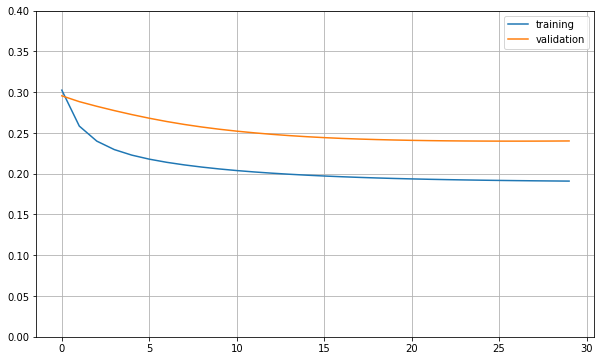

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))

ax.plot(train_loss_epochs, label = "training")
ax.plot(val_loss_epochs, label = "validation")
ax.legend()
ax.grid(True)
ax.set_ylim(0, 0.4)
plt.show();

## Testing

In [ ]:
##################### MODEL TESTING ############################
test_loss = []
test_output = []
test_target = []
for batch_train_index, dictionary_values in enumerate(dataloader_test):

    sw = get_variable(dictionary_values["sw"])
    X_ed = get_variable(dictionary_values["X_ed"])
    X = get_variable(dictionary_values["X"])
    y = get_variable(dictionary_values["y"])

    encoder_hidden = model.encoder.init_hidden(sw.shape[0])
    outputs = torch.zeros(sw.shape[0], target_len, 1)

    optimizer.zero_grad()
    encoder_hidden = repackage_hidden(encoder_hidden)
    encoder_output, encoder_hidden = model.encoder(sw, encoder_hidden)

    hidden_backward = model.backward.init_hidden(sw.shape[0])
    backward_output, _ = model.backward(X[:, 0:target_len + ADDITIONAL_STEPS_FUTURE, :], hidden_backward)

    decoder_input_point = X_ed[:, -1:, :]
    decoder_hidden = encoder_hidden
    past_observations = X_ed[:, -PAST_OBSERVATIONS_FFNN_SIZE:, :]

    # predict recursively ONLY
    for t in range(target_len):
        decoder_input = torch.cat((X[:, t:t+1, :],
                                    decoder_input_point), 2)
        hidden_state_backward = backward_output[:, t:t+1, :]
        decoder_output_point, decoder_hidden = \
        model.decoder(decoder_input, hidden_state_backward,
                        past_observations, X[:, t:t+1, :], decoder_hidden)
        outputs[:, t:t+1, :] = decoder_output_point
        decoder_input_point = decoder_output_point
        past_observations = torch.cat((past_observations[:, -PAST_OBSERVATIONS_FFNN_SIZE + 1:, :], decoder_input_point), dim = 1)

    loss = criterion(get_variable(outputs.flatten()), 
                                get_variable(y[:, 0:target_len, :].flatten()))    

    loss.backward()
    optimizer.step()
    nn.utils.clip_grad_norm_(model.parameters(), CLIP)

    test_loss.append(get_numpy(torch.sqrt(loss)).item())

    test_output.append(get_numpy(outputs))
    test_target.append(get_numpy(y[:, 0:target_len]))

test_output = arr(test_output[:-1])
test_target = arr(test_target[:-1])

print(f"test_loss: {np.mean(test_loss)}")

test_loss: 0.21983840495899873


## Plotting the results - helper functions

In [ ]:
def plotting_train_set(df_target = train_target_epochs, df_prediction = train_output_epochs):
    for i in range(10):
        epoch_last = -1
        number = train_target_epochs.shape[1] - 100 + 10*i
        addition = 3

        predictions_1 = df_prediction[epoch_last, number, 0].flatten()
        targets_1 = df_target[epoch_last, number, 0].flatten()
        predictions_2 = df_prediction[epoch_last, number + addition, 0].flatten()
        targets_2 = df_target[epoch_last, number + addition, 0].flatten()
        predictions_3 = df_prediction[epoch_last, number + 2*addition, 0].flatten()
        targets_3 = df_target[epoch_last, number + 2*addition, 0].flatten()

        fig, ax = plt.subplots(1, 3, figsize = (20, 4))
        y_min, y_max = 0, 1

        ax[0].plot(predictions_1, label = "predictions")
        ax[0].plot(targets_1, label = "targets")
        ax[0].legend()
        ax[0].grid(True)
        ax[0].set_ylim([y_min, y_max])

        ax[1].plot(predictions_2, label = "predictions")
        ax[1].plot(targets_2, label = "targets")
        ax[1].legend()
        ax[1].grid(True)
        ax[1].set_ylim([y_min, y_max])

        ax[2].plot(predictions_3, label = "predictions")
        ax[2].plot(targets_3, label = "targets")
        ax[2].legend()
        ax[2].grid(True)
        ax[2].set_ylim([y_min, y_max])

def plotting_validation_set(df_target = val_target_epochs, df_prediction = val_output_epochs):
    for i in range(10):
        epoch_last = -1
        number = 2*i
        addition = 3

        predictions_1 = df_prediction[epoch_last, number].flatten()
        targets_1 = df_target[epoch_last, number].flatten()
        predictions_2 = df_prediction[epoch_last, number + addition].flatten()
        targets_2 = df_target[epoch_last, number + addition].flatten()
        predictions_3 = df_prediction[epoch_last, number + 2*addition].flatten()
        targets_3 = df_target[epoch_last, number + 2*addition].flatten()

        fig, ax = plt.subplots(1, 3, figsize = (20, 4))
        y_min, y_max = 0, 1

        ax[0].plot(predictions_1, label = "predictions")
        ax[0].plot(targets_1, label = "targets")
        ax[0].legend()
        ax[0].grid(True)
        ax[0].set_ylim([y_min, y_max])

        ax[1].plot(predictions_2, label = "predictions")
        ax[1].plot(targets_2, label = "targets")
        ax[1].legend()
        ax[1].grid(True)
        ax[1].set_ylim([y_min, y_max])

        ax[2].plot(predictions_3, label = "predictions")
        ax[2].plot(targets_3, label = "targets")
        ax[2].legend()
        ax[2].grid(True)
        ax[2].set_ylim([y_min, y_max])

def plotting_test_set(df_target = np.squeeze(test_target), 
                      df_prediction = np.squeeze(test_output)):
    for i in range(10):
        number = 2*i
        addition = 3

        predictions_1 = df_prediction[number].flatten()
        targets_1 = df_target[number].flatten()
        predictions_2 = df_prediction[number + addition].flatten()
        targets_2 = df_target[number + addition].flatten()
        predictions_3 = df_prediction[number + 2*addition].flatten()
        targets_3 = df_target[number + 2*addition].flatten()

        fig, ax = plt.subplots(1, 3, figsize = (20, 4))
        y_min, y_max = 0, 1

        ax[0].plot(predictions_1, label = "predictions")
        ax[0].plot(targets_1, label = "targets")
        ax[0].legend()
        ax[0].grid(True)
        ax[0].set_ylim([y_min, y_max])

        ax[1].plot(predictions_2, label = "predictions")
        ax[1].plot(targets_2, label = "targets")
        ax[1].legend()
        ax[1].grid(True)
        ax[1].set_ylim([y_min, y_max])

        ax[2].plot(predictions_3, label = "predictions")
        ax[2].plot(targets_3, label = "targets")
        ax[2].legend()
        ax[2].grid(True)
        ax[2].set_ylim([y_min, y_max])

## Plotting

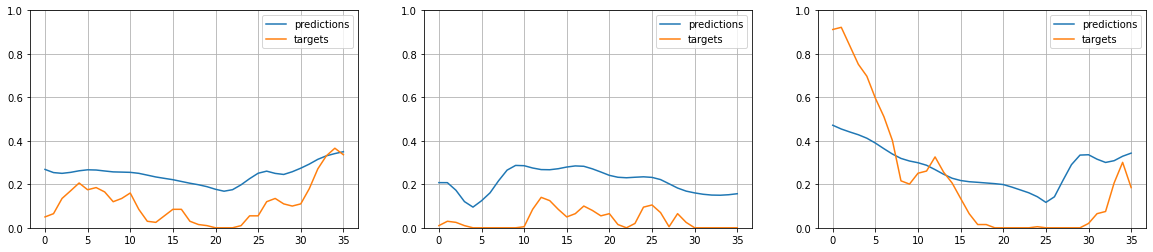

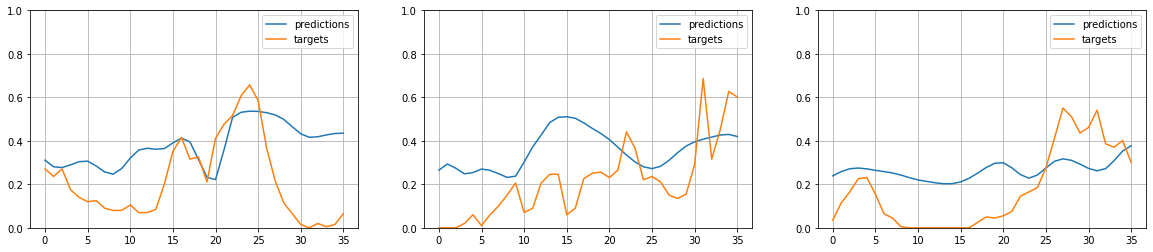

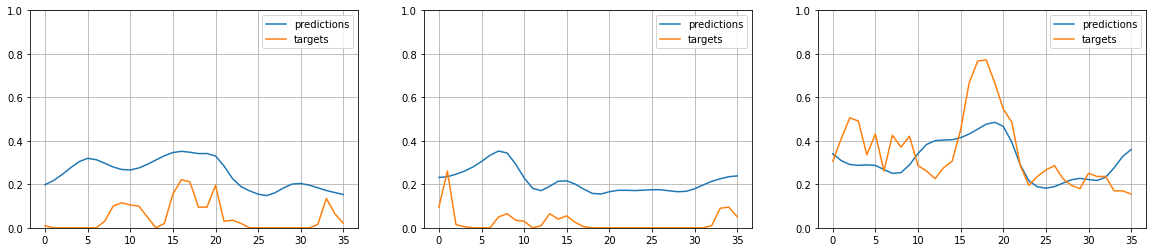

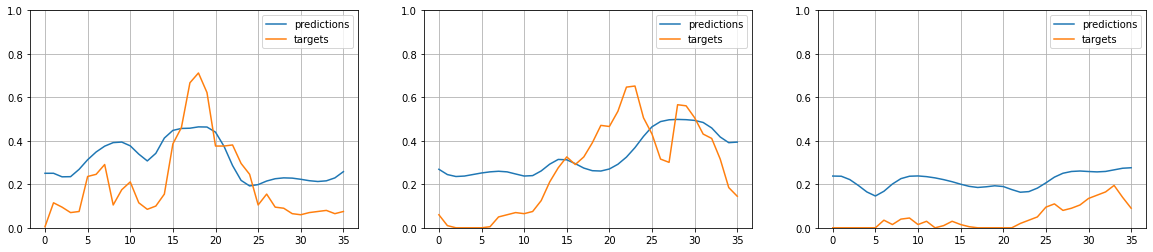

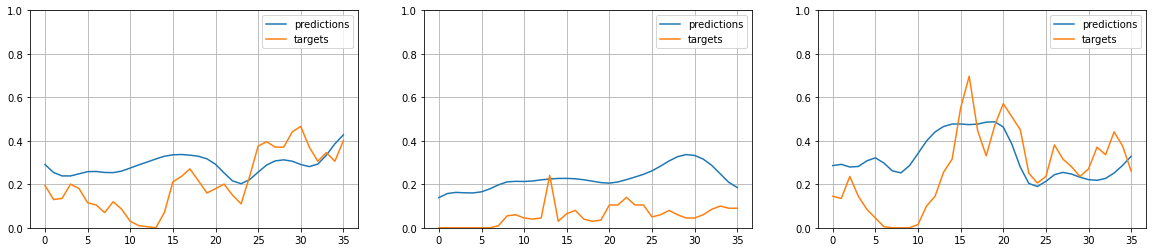

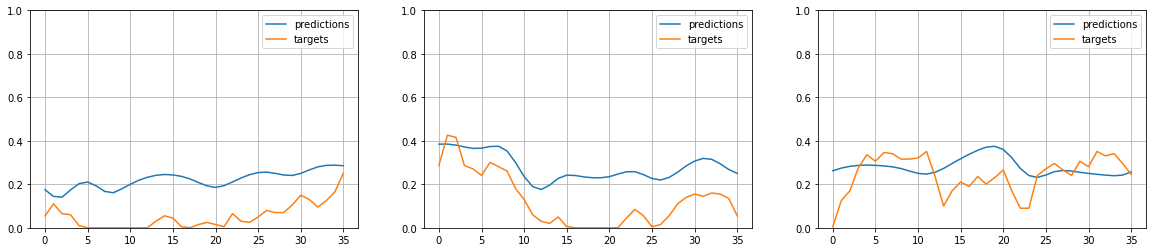

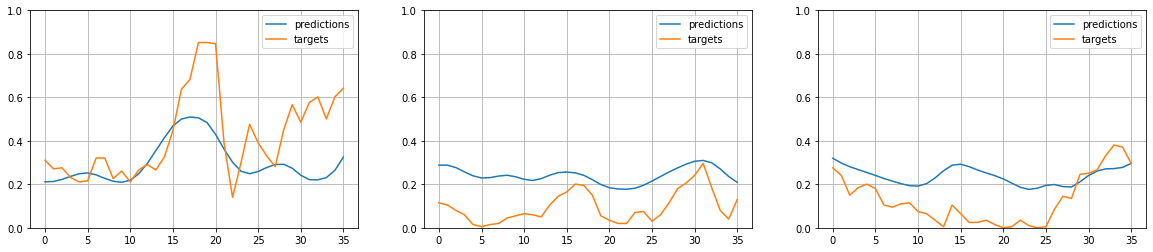

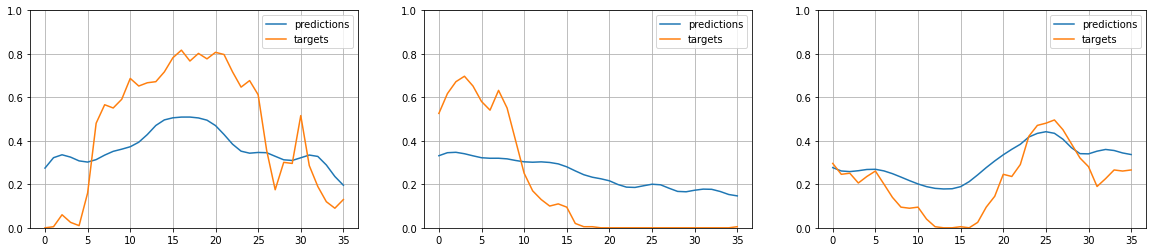

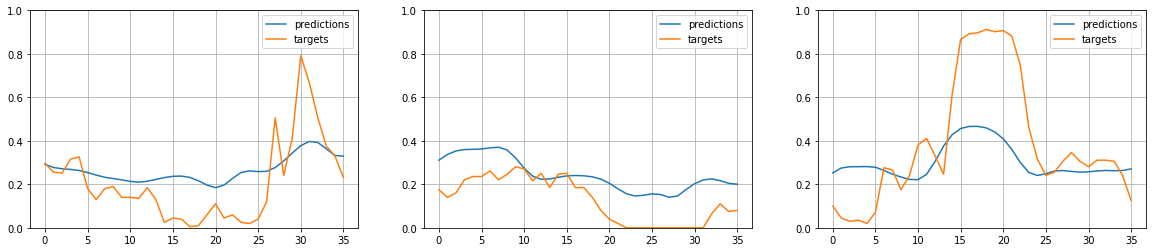

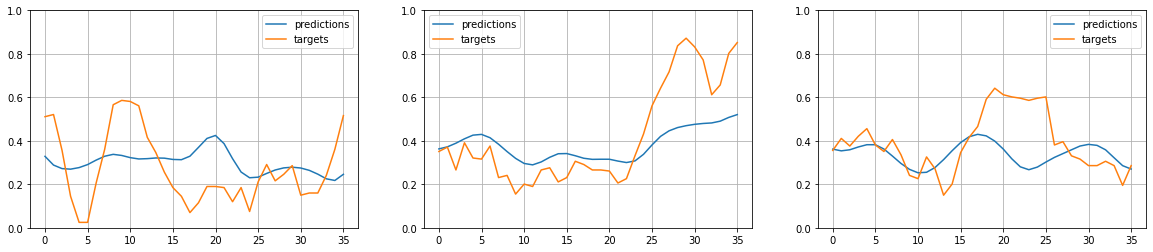

In [ ]:
plotting_train_set()

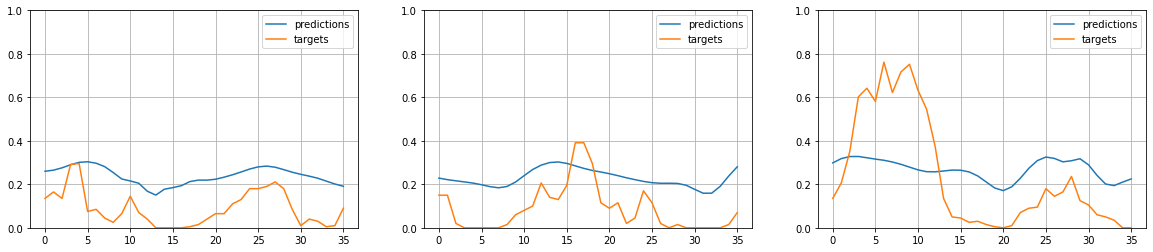

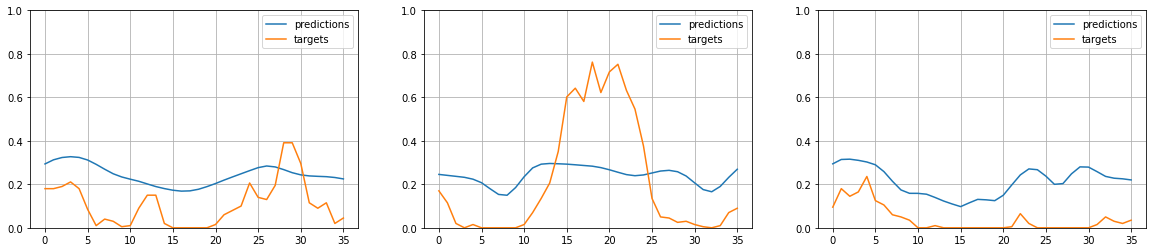

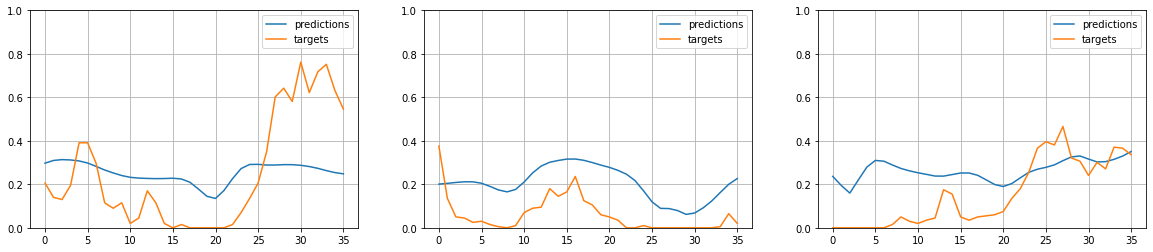

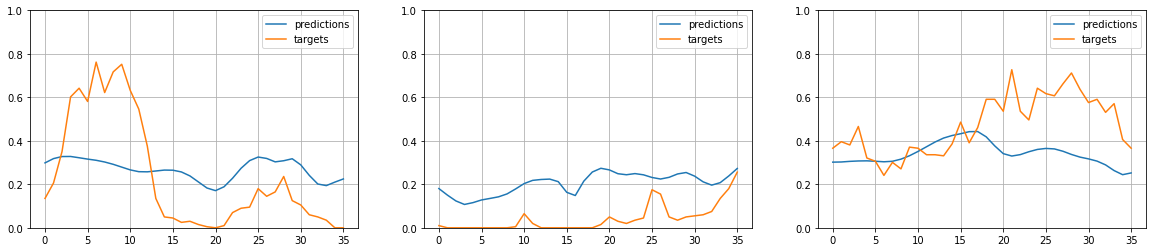

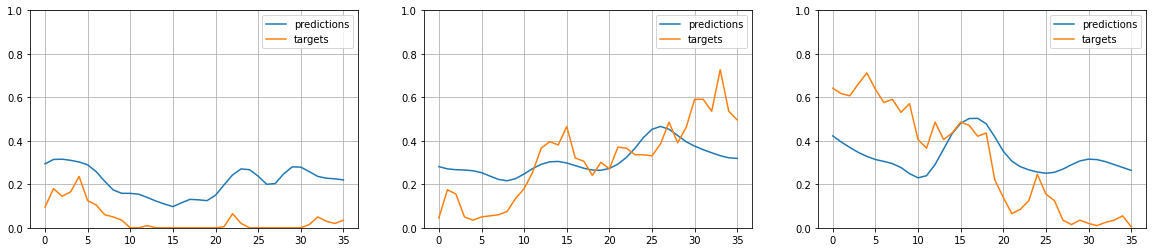

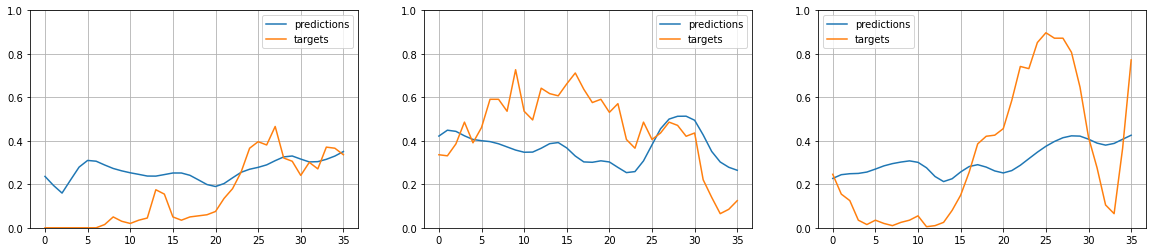

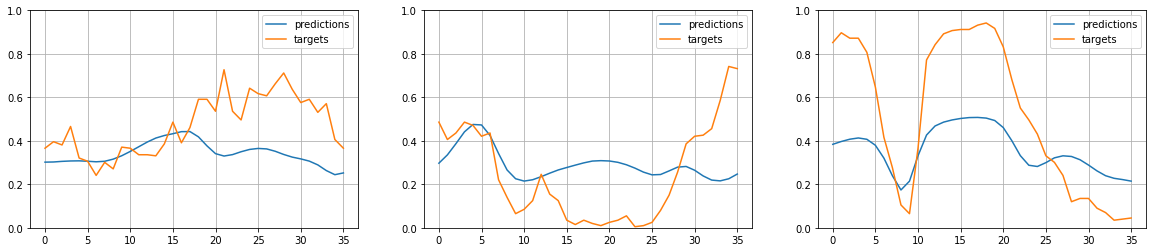

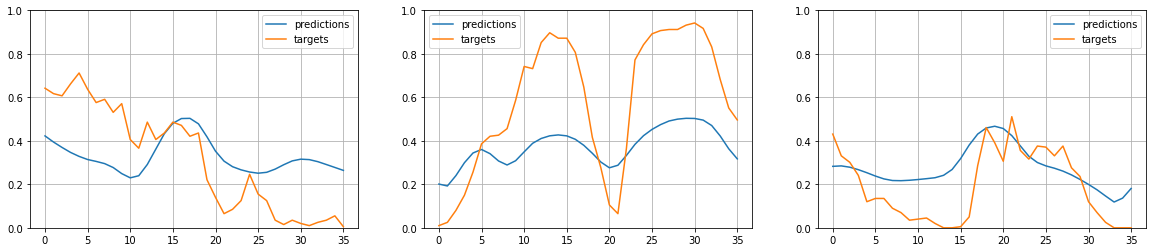

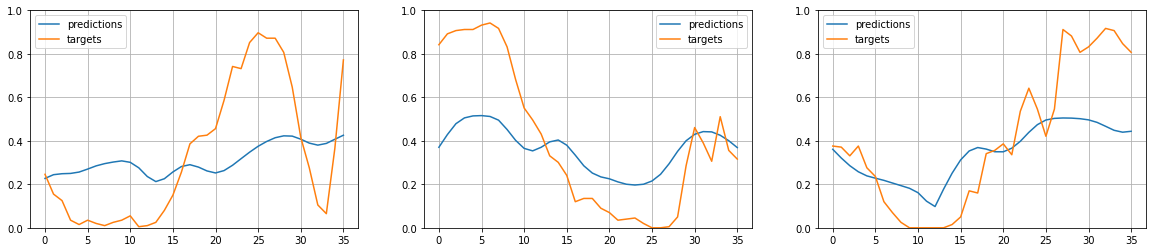

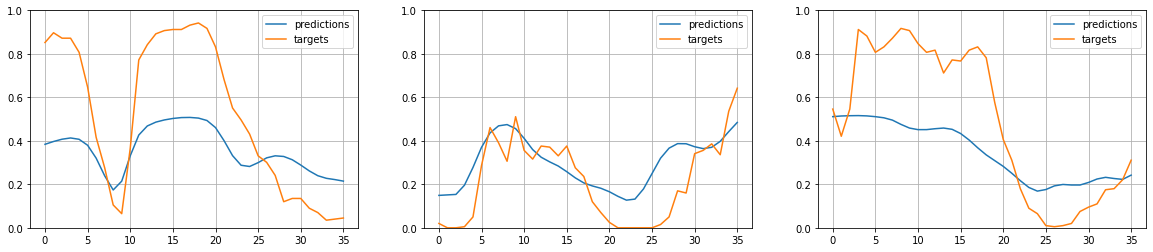

In [ ]:
plotting_validation_set()

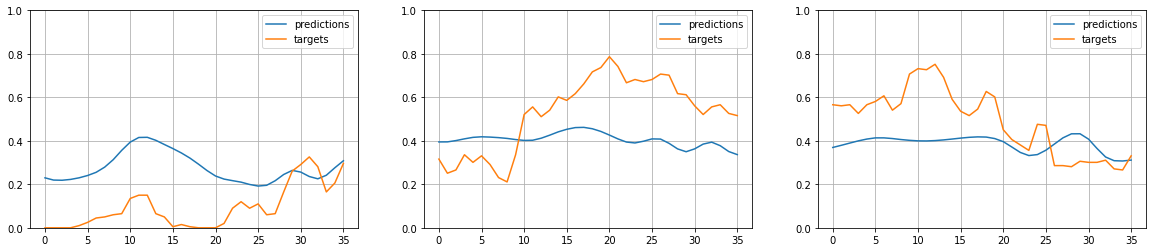

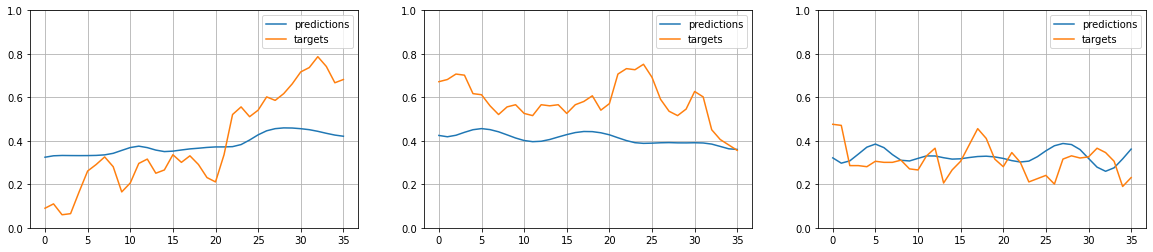

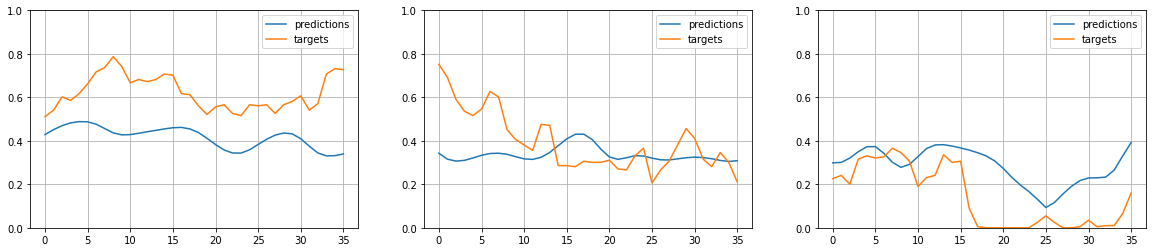

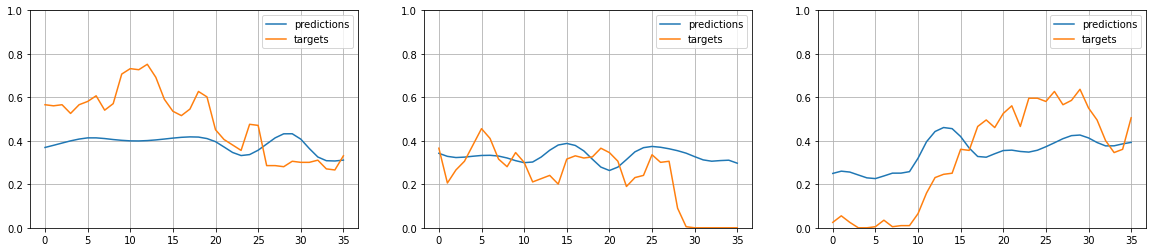

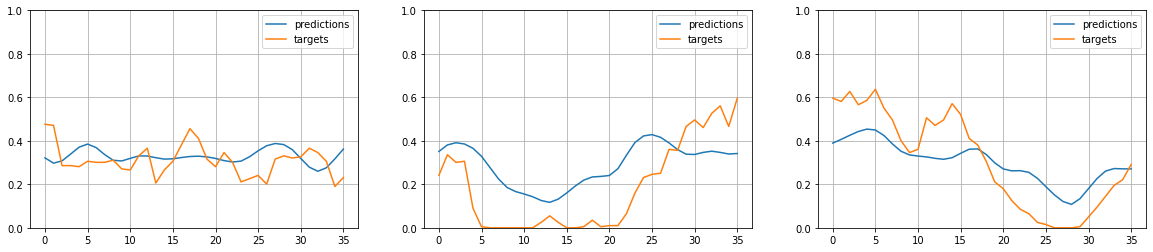

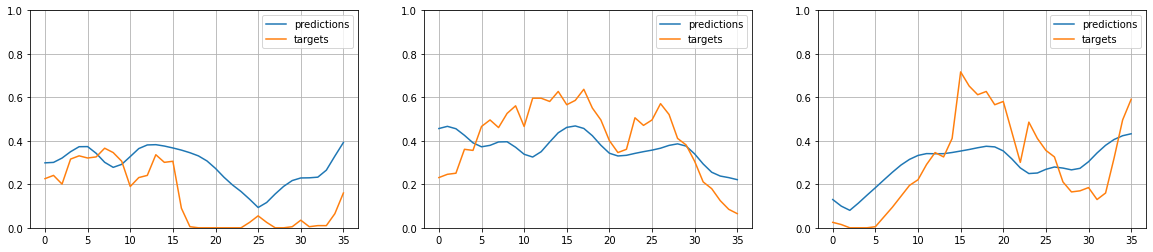

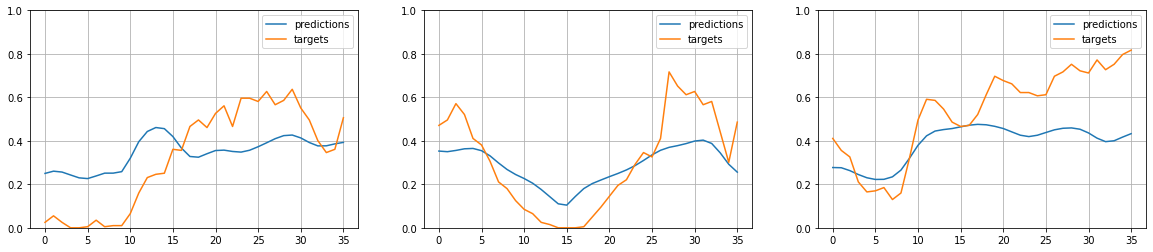

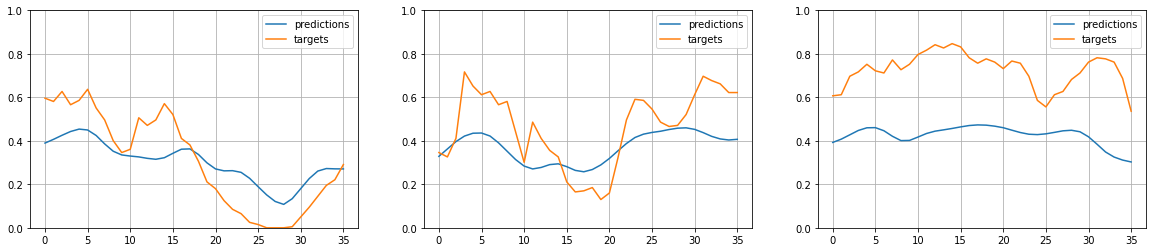

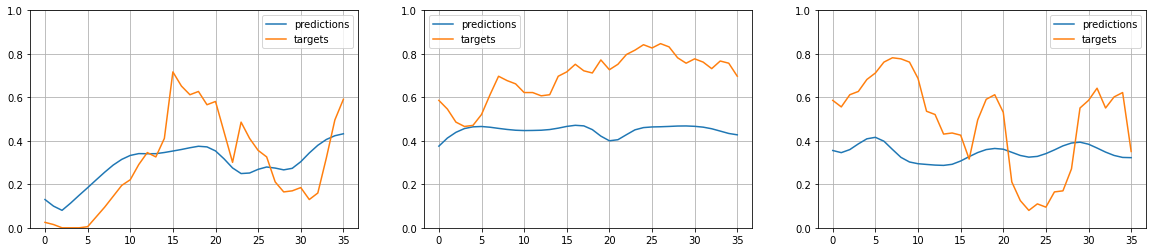

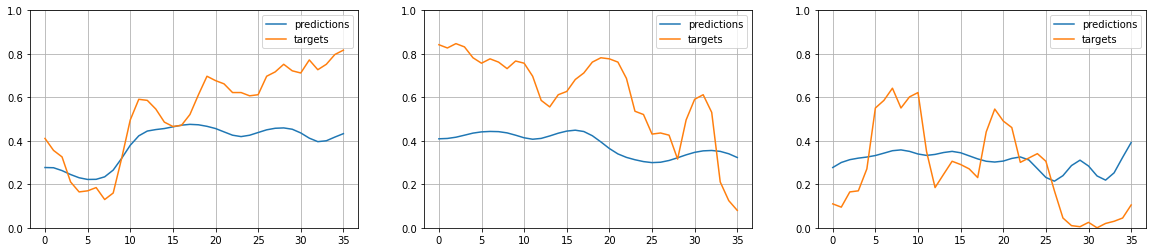

In [ ]:
plotting_test_set()